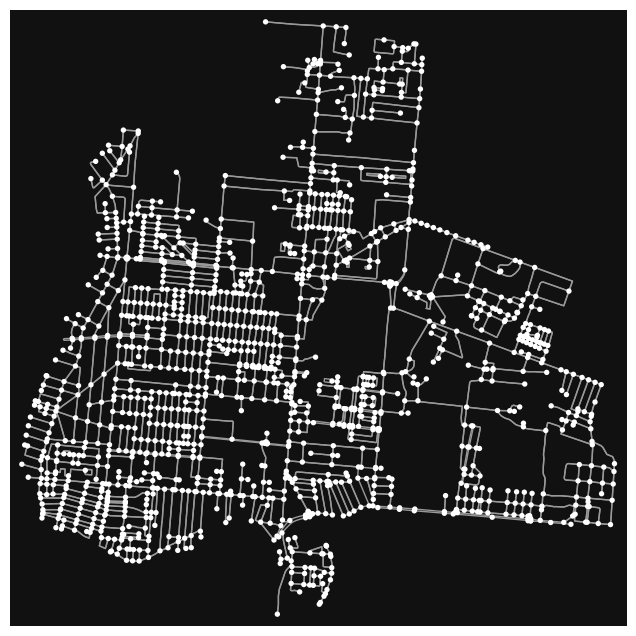

In [ ]:
import osmnx as ox

# Charger le graphe routier de Bordj El Bahri
place_name = "Bordj El Bahri, Algeria"
G = ox.graph_from_place(place_name, network_type="drive")

# Visualiser
ox.plot_graph(G)



In [4]:
# Liste de quelques nœuds avec leurs attributs
for node, data in list(G.nodes(data=True))[:5]:
    print(f"Nœud ID: {node}")
    print(data)
    print("------")


Nœud ID: 283506109
{'y': 36.7799406, 'x': 3.2488399, 'street_count': 3}
------
Nœud ID: 283506121
{'y': 36.8020702, 'x': 3.2511461, 'street_count': 3}
------
Nœud ID: 283525578
{'y': 36.7777233, 'x': 3.2519542, 'street_count': 3}
------
Nœud ID: 283525776
{'y': 36.8040203, 'x': 3.2513337, 'street_count': 4}
------
Nœud ID: 283526039
{'y': 36.7790066, 'x': 3.2487227, 'street_count': 3}
------


In [5]:
# Liste de quelques arêtes avec leurs attributs
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"Arc entre {u} → {v}")
    print(data)
    print("------")


Arc entre 283506109 → 3590153557
{'osmid': 25989376, 'highway': 'primary', 'lanes': '2', 'maxspeed': '30', 'oneway': True, 'ref': 'RN 24', 'reversed': False, 'length': np.float64(26.50886397047564)}
------
Arc entre 283506109 → 3590153561
{'osmid': 1101550957, 'highway': 'primary', 'lanes': '2', 'maxspeed': '30', 'oneway': True, 'reversed': False, 'length': np.float64(21.122258538730602)}
------
Arc entre 283506121 → 9005089296
{'osmid': 942717452, 'highway': 'primary', 'ref': 'RN 24', 'oneway': False, 'reversed': False, 'length': np.float64(11.14707810260764)}
------
Arc entre 283506121 → 9005089297
{'osmid': 942717452, 'highway': 'primary', 'ref': 'RN 24', 'oneway': False, 'reversed': True, 'length': np.float64(10.92234825855954)}
------
Arc entre 283506121 → 9355175041
{'osmid': 1014000889, 'highway': 'residential', 'oneway': False, 'reversed': True, 'length': np.float64(107.25529285846375), 'geometry': <LINESTRING (3.251 36.802, 3.252 36.802, 3.252 36.802, 3.252 36.802)>}
------


Nœud départ : 283506109, Nœud arrivée : 283526039


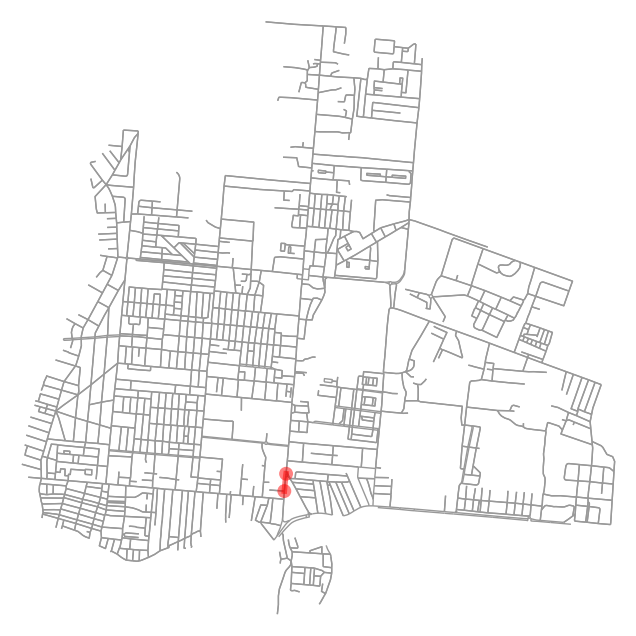

In [6]:


import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Étape 4 : Choisir deux adresses ou coordonnées GPS
# Exemple : deux points dans Alger
origin = (36.7799406, 3.2488399)   # Place des Martyrs
destination = (36.7790066, 3.2487227)  # Jardin d'Essai

# Trouver les nœuds les plus proches de ces coordonnées
orig_node = ox.distance.nearest_nodes(G, origin[1], origin[0])
dest_node = ox.distance.nearest_nodes(G, destination[1], destination[0])

print(f"Nœud départ : {orig_node}, Nœud arrivée : {dest_node}")

# Étape 5 : Calculer le chemin le plus court (distance)
route = nx.shortest_path(G, orig_node, dest_node, weight="length")

# Étape 6 : Visualiser l'itinéraire
fig, ax = ox.plot_graph_route(G, route, route_linewidth=4, node_size=0, bgcolor='w')


In [4]:
import osmnx as ox
import networkx as nx
from shortest_path import compute_shortest_path
from graph_loader import load_graph


def calculate_route_length(G, path):
    """Compute total length of a path in meters."""
    length = 0
    for u, v in zip(path[:-1], path[1:]):
        # certaines arêtes peuvent avoir plusieurs versions (multigraph)
        edge_data = min(G[u][v].values(), key=lambda x: x.get("length", float("inf")))
        length += edge_data.get("length", 0)
    return length


def evaluate_match(G, driver, passenger):
    """
    Compute extra distance if driver picks up passenger.
    Returns detour in meters and the new path.
    """
    # trouver les nœuds les plus proches
    orig_node = ox.distance.nearest_nodes(G, driver["origin"][1], driver["origin"][0])
    dest_node = ox.distance.nearest_nodes(G, driver["destination"][1], driver["destination"][0])
    p_orig = ox.distance.nearest_nodes(G, passenger["origin"][1], passenger["origin"][0])
    p_dest = ox.distance.nearest_nodes(G, passenger["destination"][1], passenger["destination"][0])

    # route directe du conducteur
    base_path = compute_shortest_path(G, orig_node, dest_node)
    base_dist = calculate_route_length(G, base_path)

    # route avec prise en charge du passager
    path_with_p = (
        compute_shortest_path(G, orig_node, p_orig)[:-1] +
        compute_shortest_path(G, p_orig, p_dest)[:-1] +
        compute_shortest_path(G, p_dest, dest_node)
    )
    new_dist = calculate_route_length(G, path_with_p)

    detour = new_dist - base_dist
    return detour, path_with_p


def match_passengers(G, drivers, passengers, detour_threshold=2000):
    """
    Match passengers to drivers if detour is acceptable.
    """
    matches = {}
    for driver in drivers:
        assigned = []
        for passenger in passengers:
            try:
                detour, path_with_p = evaluate_match(G, driver, passenger)
                if detour < detour_threshold and len(assigned) < driver["capacity"]:
                    assigned.append({"passenger": passenger["id"], "detour": detour})
            except nx.NetworkXNoPath:
                # si pas de chemin possible entre deux points
                continue
        matches[driver["id"]] = assigned
    return matches


def main():
    # Charger ou construire le graphe
    G = load_graph("Algiers, Algeria")

    drivers = [
        {"id": "D1", "origin": (36.75, 3.06), "destination": (36.78, 3.05), "capacity": 2},
    ]
    passengers = [
        {"id": "P1", "origin": (36.76, 3.07), "destination": (36.79, 3.05)},
        {"id": "P2", "origin": (36.755, 3.065), "destination": (36.781, 3.049)},
    ]

    result = match_passengers(G, drivers, passengers)
    print(result)


if __name__ == "__main__":
    main()


{'D1': [{'passenger': 'P2', 'detour': np.float64(1901.7269320595333)}]}
